In [6]:
import exmel
from exmel.alignment import FrozenMatch

dataset = exmel.Dataset("dataset_v1")

In [7]:
song_name_to_candidates: dict[str, list[FrozenMatch]] = {}
for song in dataset:
    candidates = exmel.align(
        song.melody,
        song.performance,
        exmel.AlignConfig(candidate_min_score=0, candidate_min_length=8, hop_length=1, miss_tolerance=2),
        skip_wisp=True)
    song_name_to_candidates[song.name] = candidates

Scanning alignments:   0%|          | 0/451 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/355 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/215 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/277 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/365 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/345 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/311 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/380 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/469 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/798 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/387 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/413 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/495 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/447 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/344 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/231 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/345 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/491 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/511 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/375 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/321 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/365 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/654 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/552 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/356 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/401 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/332 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/318 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/338 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/348 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/495 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/336 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/304 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/543 [00:00<?, ?it/s]

In [8]:
import pickle

with open("song_name_to_candidates.pkl", "wb") as f:
    pickle.dump(song_name_to_candidates, f)

In [11]:
from dataclasses import dataclass
from tqdm.auto import tqdm
import exmel

@dataclass(frozen=True, slots=True)
class Detection:
    tp: int
    fp: int
    start: float
    end: float

detections: dict[str, list[Detection]] = {}
for song in tqdm(dataset):
    detections[song.name] = []
    for match in song_name_to_candidates[song.name]:
        assert song.ground_truth is not None
        tp, fp = exmel.tp_fp(match, song.ground_truth)
        detections[song.name].append(
            Detection(tp, fp, match.start, match.end))

  0%|          | 0/34 [00:00<?, ?it/s]

In [12]:
import pickle

with open("detections.pkl", "wb") as f:
    pickle.dump(detections, f)

In [13]:
from tqdm.auto import tqdm
from exmel.sequence import song_stats

name_to_scores: dict[str, list[float]] = {}
for song in tqdm(dataset):
    # score_model.load_song_stats(song_stats(song.melody, song.performance))
    candidates = song_name_to_candidates[song.name]
    dts = detections[song.name]
    scores: list[float] = []
    for c, d in zip(candidates, dts):
        tp, fp = d.tp, d.fp
        scores.append(tp - fp)
    name_to_scores[song.name] = scores

  0%|          | 0/34 [00:00<?, ?it/s]

In [14]:
from itertools import product
from exmel.wisp import weighted_interval_scheduling
from exmel.alignment import Alignment, concat_matches
import numpy as np


pen_min_tuple = list(product([0], range(31)))

f1_list: list[float] = []
precision_list: list[float] = []
recall_list: list[float] = []

for p, m in pen_min_tuple:
    f1_score = 0
    precision = 0
    recall = 0
    for song in dataset:
        scores = np.array(name_to_scores[song.name]) - p
        candidates = song_name_to_candidates[song.name]
        updated_candidates: list[FrozenMatch] = []
        for candidate, score in zip(candidates, scores):
            if score >= m:
                updated_candidates.append(candidate.update_score(score))
        candidates = updated_candidates
        opt_score, opt_subset = weighted_interval_scheduling(
            candidates, return_subset=True, verbose=False)
        discarded_matches = [match for match in candidates if match not in opt_subset]
        concat_events = concat_matches(opt_subset)
        alignment = Alignment(concat_events, opt_subset, discarded_matches, opt_score,
                        sum(match.sum_miss for match in opt_subset),
                        sum(match.sum_error for match in opt_subset))
        assert song.ground_truth is not None
        result = exmel.evaluate_melody(song.ground_truth, alignment.events, plot=False)
        f1_score += result.f1_score
        precision += result.precision
        recall += result.recall
    f1_score /= len(dataset)
    precision /= len(dataset)
    recall /= len(dataset)
    f1_list.append(f1_score)
    precision_list.append(precision)
    recall_list.append(recall)
    print(f"{p=}, {m=}, {f1_score=}, {precision=}, {recall=}")

p=0, m=0, f1_score=0.9718712122973228, precision=0.9967551966675074, recall=0.9487391158460824
p=0, m=1, f1_score=0.9718712122973228, precision=0.9967551966675074, recall=0.9487391158460824
p=0, m=2, f1_score=0.9718712122973228, precision=0.9967551966675074, recall=0.9487391158460824
p=0, m=3, f1_score=0.9718712122973228, precision=0.9967551966675074, recall=0.9487391158460824
p=0, m=4, f1_score=0.9718712122973228, precision=0.9967551966675074, recall=0.9487391158460824
p=0, m=5, f1_score=0.9717463023402301, precision=0.9969742731524387, recall=0.9483339492700883
p=0, m=6, f1_score=0.9717204731762341, precision=0.9970209453553942, recall=0.9482460217223876
p=0, m=7, f1_score=0.971393494938539, precision=0.997145411033066, recall=0.9475388822093603
p=0, m=8, f1_score=0.9712458352722217, precision=0.9977075470392524, recall=0.9468244459733091
p=0, m=9, f1_score=0.9686616377195589, precision=0.9972910528966168, recall=0.942483308990252
p=0, m=10, f1_score=0.9662067027732432, precision=0.9

KeyboardInterrupt: 

# Real tp-fp

In [4]:
from tqdm.auto import tqdm
from exmel.sequence import song_stats

name_to_scores: dict[str, list[float]] = {}
for song in tqdm(dataset):
    # score_model.load_song_stats(song_stats(song.melody, song.performance))
    candidates = song_name_to_candidates[song.name]
    scores: list[float] = []
    for c in candidates:
        assert song.ground_truth is not None
        tp, fp = exmel.tp_fp(c, song.ground_truth)
        scores.append(tp-fp)
    name_to_scores[song.name] = scores

  0%|          | 0/17 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:
from itertools import product
from exmel.wisp import weighted_interval_scheduling
from exmel.alignment import Alignment, concat_matches
import numpy as np


pen_min_tuple = list(product([0], range(31)))

f1_list: list[float] = []
precision_list: list[float] = []
recall_list: list[float] = []

for p, m in pen_min_tuple:
    f1_score = 0
    precision = 0
    recall = 0
    for song in tqdm(dataset, desc=f"{p=}, {m=}"):
        scores = np.array(name_to_scores[song.name]) - p
        candidates = song_name_to_candidates[song.name]
        updated_candidates: list[FrozenMatch] = []
        for candidate, score in zip(candidates, scores):
            if score >= m:
                updated_candidates.append(candidate.update_score(score))
        candidates = updated_candidates
        opt_score, opt_subset = weighted_interval_scheduling(
            candidates, return_subset=True, verbose=False)
        discarded_matches = [match for match in candidates if match not in opt_subset]
        concat_events = concat_matches(opt_subset)
        alignment = Alignment(concat_events, opt_subset, discarded_matches, opt_score,
                        sum(match.sum_miss for match in opt_subset),
                        sum(match.sum_error for match in opt_subset))
        assert song.ground_truth is not None
        result = exmel.evaluate_melody(song.ground_truth, alignment.events, plot=False)
        f1_score += result.f1_score
        precision += result.precision
        recall += result.recall
    f1_score /= len(dataset)
    precision /= len(dataset)
    recall /= len(dataset)
    f1_list.append(f1_score)
    precision_list.append(precision)
    recall_list.append(recall)

p=0, m=0:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=1:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=2:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=3:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=4:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=5:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=6:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=7:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=8:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=9:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=10:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=11:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=12:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=13:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=14:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=15:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=16:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=17:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=18:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=19:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=20:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=21:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=22:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=23:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=24:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=25:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=26:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=27:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=28:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=29:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=30:   0%|          | 0/17 [00:00<?, ?it/s]

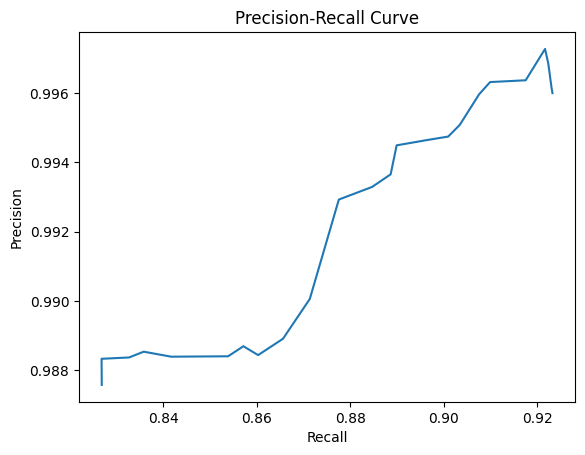

In [5]:
from matplotlib import pyplot as plt

plt.plot(recall_list, precision_list)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [6]:
for p, f1, pre, rec in zip(range(31), f1_list, precision_list, recall_list):
    print(f"{p=}, {f1=}, {pre=}, {rec=}")

p=0, f1=0.957593118549517, pre=0.996000926885767, rec=0.9232043386284174
p=1, f1=0.957593118549517, pre=0.996000926885767, rec=0.9232043386284174
p=2, f1=0.957593118549517, pre=0.996000926885767, rec=0.9232043386284174
p=3, f1=0.957593118549517, pre=0.996000926885767, rec=0.9232043386284174
p=4, f1=0.957593118549517, pre=0.996000926885767, rec=0.9232043386284174
p=5, f1=0.9575511082385807, pre=0.9961525308677404, rec=0.9230052377337385
p=6, f1=0.9575511082385807, pre=0.9961525308677404, rec=0.9230052377337385
p=7, f1=0.9575511082385807, pre=0.9961525308677404, rec=0.9230052377337385
p=8, f1=0.9575511082385807, pre=0.9961525308677404, rec=0.9230052377337385
p=9, f1=0.9574452482425111, pre=0.9968502851216979, rec=0.9223140053254463
p=10, f1=0.9572324720668054, pre=0.9972783900491119, rec=0.9216169901648948
p=11, f1=0.9544639906658406, pre=0.9963727357064606, rec=0.9174760925151231
p=12, f1=0.9500140697841374, pre=0.9963207563088533, rec=0.9098651376052027
p=13, f1=0.9484881749225719, pre

# With R

In [ ]:
from tqdm.auto import tqdm
from exmel.sequence import song_stats

R = 0.97

name_to_scores: dict[str, list[float]] = {}
for song in tqdm(dataset):
    # score_model.load_song_stats(song_stats(song.melody, song.performance))
    candidates = song_name_to_candidates[song.name]
    dts = detections[song.name]
    scores: list[float] = []
    for c, d in zip(candidates, dts):
        tp, fp = d.tp, d.fp
        scores.append((2-R)*tp - R*fp)
    name_to_scores[song.name] = scores

  0%|          | 0/17 [00:00<?, ?it/s]

In [14]:
from itertools import product
from exmel.wisp import weighted_interval_scheduling
from exmel.alignment import Alignment, concat_matches
import numpy as np


pen_min_tuple = list(product([0], range(31)))

f1_list: list[float] = []
precision_list: list[float] = []
recall_list: list[float] = []

for p, m in pen_min_tuple:
    f1_score = 0
    precision = 0
    recall = 0
    for song in tqdm(dataset, desc=f"{p=}, {m=}"):
        scores = np.array(name_to_scores[song.name]) - p
        candidates = song_name_to_candidates[song.name]
        updated_candidates: list[FrozenMatch] = []
        for candidate, score in zip(candidates, scores):
            if score >= m:
                updated_candidates.append(candidate.update_score(score))
        candidates = updated_candidates
        opt_score, opt_subset = weighted_interval_scheduling(
            candidates, return_subset=True, verbose=False)
        discarded_matches = [match for match in candidates if match not in opt_subset]
        concat_events = concat_matches(opt_subset)
        alignment = Alignment(concat_events, opt_subset, discarded_matches, opt_score,
                        sum(match.sum_miss for match in opt_subset),
                        sum(match.sum_error for match in opt_subset))
        assert song.ground_truth is not None
        result = evaluate_melody(song.ground_truth, alignment.events, plot=False)
        f1_score += result.f1_score
        precision += result.precision
        recall += result.recall
    f1_score /= len(dataset)
    precision /= len(dataset)
    recall /= len(dataset)
    f1_list.append(f1_score)
    precision_list.append(precision)
    recall_list.append(recall)

p=0, m=0:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=1:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=2:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=3:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=4:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=5:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=6:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=7:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=8:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=9:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=10:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=11:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=12:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=13:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=14:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=15:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=16:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=17:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=18:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=19:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=20:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=21:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=22:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=23:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=24:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=25:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=26:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=27:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=28:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=29:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=30:   0%|          | 0/17 [00:00<?, ?it/s]

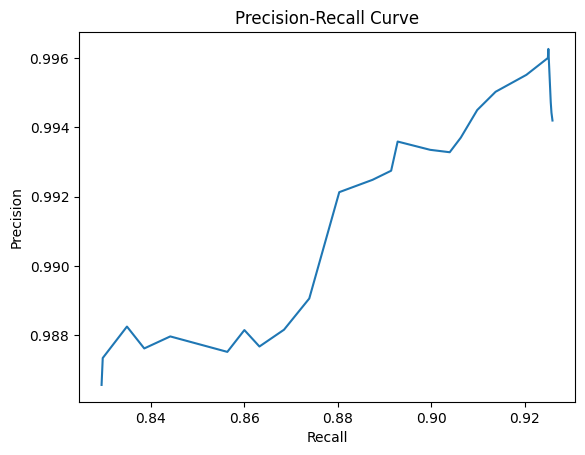

In [15]:
from matplotlib import pyplot as plt

plt.plot(recall_list, precision_list)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [16]:
for p, f1, pre, rec in zip(range(31), f1_list, precision_list, recall_list):
    print(f"{p=}, {f1=}, {pre=}, {rec=}")

p=0, f1=0.9582755087520316, pre=0.9941980488022901, rec=0.9259363690809265
p=1, f1=0.9582755087520316, pre=0.9941980488022901, rec=0.9259363690809265
p=2, f1=0.9582755087520316, pre=0.9941980488022901, rec=0.9259363690809265
p=3, f1=0.9582755087520316, pre=0.9941980488022901, rec=0.9259363690809265
p=4, f1=0.9582755087520316, pre=0.9941980488022901, rec=0.9259363690809265
p=5, f1=0.9582687022604259, pre=0.9944225393140584, rec=0.9257203708089126
p=6, f1=0.9582687022604259, pre=0.9944225393140584, rec=0.9257203708089126
p=7, f1=0.9583106376903028, pre=0.9947279074772103, rec=0.925564799379715
p=8, f1=0.9583106376903028, pre=0.9947279074772103, rec=0.925564799379715
p=9, f1=0.9586962567332246, pre=0.9962663263336807, rec=0.9250552376596105
p=10, f1=0.9585372332462411, pre=0.9960051167857792, rec=0.9249556901420769
p=11, f1=0.9556941606727111, pre=0.9955174939099325, rec=0.9203535979903081
p=12, f1=0.9517409598345546, pre=0.995029142537066, rec=0.9137747110357843
p=13, f1=0.94922457380662